# CS 6140 Machine Learning Project:

In [1]:
# I needed to disable ssl to download the dataset
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

### Table of Contents:

1. Base Model of Implementation 
2. Ridge Regression using California Housing Data (LIME, SHAP)
3. Random Forest Classification using Breast Cancer Data (LIME, SHAP)
4. Open-Source GenAI Classification using AG News (Attributions)
5. Closed-Source GenAI Classification using Prompting (Masking)
6. Random Forest Classification (Counterfactuals)
7. Deep Learning Classification using MNIST

## 1. Base Model

In [72]:
import seaborn as sns
sns.set_style("whitegrid")
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
import shap
from lime import lime_tabular
from sklearn.datasets import load_breast_cancer
        
class BaseModelExplainer:
    def __init__(self):
        """
        base class
        """
        self.data = None
        self.X = None
        self.y = None
        self.model = None
        self.explainer = None

    def load_data(self):
        """
        load data
        """
        raise NotImplementedError("Subclasses should implement this method.")

    def preprocess_data(self):
        """
        Ppreprocess
        """
        pass

    def train_model(self):
        """
        train
        """
        raise NotImplementedError("Subclasses should implement this method.")

    def evaluate_model(self):
        """
        eval
        """
        raise NotImplementedError("Subclasses should implement this method.")

    def explain_model(self):
        """
        eplain
        """
        raise NotImplementedError("Subclasses should implement this method.")

    def visualize_data(self):
        """
        Visualize
        """
        pass

    def visualize_explanations(self):
        """
        Visualize the model explanations.
        """
        pass

### 2. Regression (California Housing)

In [61]:
class RegressionModelExplainer(BaseModelExplainer):
    """
    Regression model for cali data
    """
    def __init__(self):
        super().__init__()

    def load_data(self):
        """
        Load the California data
        """
        from sklearn.datasets import fetch_california_housing

        housing = fetch_california_housing()
        self.data = pd.DataFrame(housing.data, columns=housing.feature_names)
        self.data['MedHouseVal'] = housing.target

        self.X = self.data.drop('MedHouseVal', axis=1)
        self.y = self.data['MedHouseVal']

    def preprocess_data(self):
        """
        removing outliers and scaling features
        """
        
        def remove_outliers(df, features):
            """Remove outliars in data"""
            for feature in features:
                Q1 = df[feature].quantile(0.25)
                Q3 = df[feature].quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                df = df[(df[feature] >= lower_bound) & (df[feature] <= upper_bound)]
            return df
    
        # putliers
        features = self.X.columns
        self.data = remove_outliers(self.data, features)
    
        self.X = self.data.drop('MedHouseVal', axis=1)
        self.y = self.data['MedHouseVal']
    
        self.feature_names = self.X.columns.tolist()
    
        # scale
        scaler = StandardScaler()
        self.X = scaler.fit_transform(self.X)



    def train_model(self):
        """
        Ridge Regression model
        """

        # split
        X_train, X_test, y_train, y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=42
        )

        # scale
        scaler = StandardScaler()
        self.X_train = scaler.fit_transform(X_train)
        self.X_test = scaler.transform(X_test)
        self.y_train = y_train
        self.y_test = y_test

        # Train
        self.model = Ridge(alpha=1.0)
        self.model.fit(self.X_train, self.y_train)

    def evaluate_model(self):
        """
        eval the regression model
        """

        # pred
        y_pred = self.model.predict(self.X_test)
    
        # metrics
        mse = mean_squared_error(self.y_test, y_pred)
        r2 = r2_score(self.y_test, y_pred)
    
        # print the metrics
        print(f"Regression Model Evaluation:")
        print(f"Mean Squared Error: {mse:.2f}")
        print(f"R-squared: {r2:.2f}")
    
        # Scatter plot
        plt.figure(figsize=(8, 6))
        plt.scatter(self.y_test, y_pred, alpha=0.7, edgecolor='k', label='Predicted vs Actual')
        plt.plot(
            [min(self.y_test), max(self.y_test)],
            [min(self.y_test), max(self.y_test)],
            color='red',
            linestyle='--',
            label='Perfect Prediction'
        )
        plt.title('Predicted vs Actual Values')
        plt.xlabel('Actual Values')
        plt.ylabel('Predicted Values')
        plt.legend()
        plt.grid(True)
        plt.text(
            0.05, 0.95, f'$R^2$: {r2:.2f}', transform=plt.gca().transAxes,
            fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8)
        )
        plt.show()


    def explain_model(self):
        """
        SHAP and LIM
        """
        
        # SHAP
        explainer_shap = shap.Explainer(self.model, self.X_train)
        self.shap_values = explainer_shap(self.X_test)
        self.explainer_shap = explainer_shap
    
        # LIME
        explainer_lime = lime_tabular.LimeTabularExplainer(
            self.X_train,
            feature_names=self.feature_names,
            verbose=True,
            mode='regression'
        )
        self.explainer_lime = explainer_lime

    def visualize_explanations(self):
        """
        Visualize
        """
        import shap
    
        # SHAP summary plot
        shap.summary_plot(self.shap_values, self.X_test, feature_names=self.feature_names)
    
        # LIME explanation 
        i = 0 
        exp = self.explainer_lime.explain_instance(
            self.X_test[i],
            self.model.predict,
            num_features=5
        )
        exp.show_in_notebook(show_table=True)

    def visualize_data(self):
        """
        visualize the distribution
        """
        plt.figure(figsize=(10, 6))
        sns.histplot(self.y, bins=30, kde=True)
        plt.xlabel('Median House Value')
        plt.ylabel('Frequency')
        plt.title('Distribution of Median House Value')
        plt.show()

In [62]:
regression_explainer = RegressionModelExplainer()
regression_explainer.load_data()
regression_explainer.preprocess_data()

In [63]:
regression_explainer.data.shape

(16813, 9)

In [6]:
regression_explainer.data.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
count,16813.000000,16813.000000,16813.000000,16813.000000,16813.000000,16813.000000,16813.000000,16813.000000,16813.000000
mean,3.711118,29.665735,5.165993,1.047427,1271.323143,2.846678,35.654022,-119.626791,2.022104
std,1.478956,12.254293,1.047209,0.065861,631.894783,0.631920,2.131764,1.993803,1.070322
min,0.536000,1.000000,2.133929,0.869822,5.000000,1.161290,32.540000,-124.350000,0.149990
25%,2.583300,19.000000,4.431250,1.003155,811.000000,2.416357,33.940000,-121.830000,1.206000
50%,3.533300,30.000000,5.148936,1.044118,1157.000000,2.797251,34.280000,-118.560000,1.813000
75%,4.650000,38.000000,5.865306,1.088825,1633.000000,3.230903,37.730000,-118.040000,2.594000
max,8.011300,52.000000,8.275862,1.232975,3183.000000,4.571046,41.950000,-114.570000,5.000010


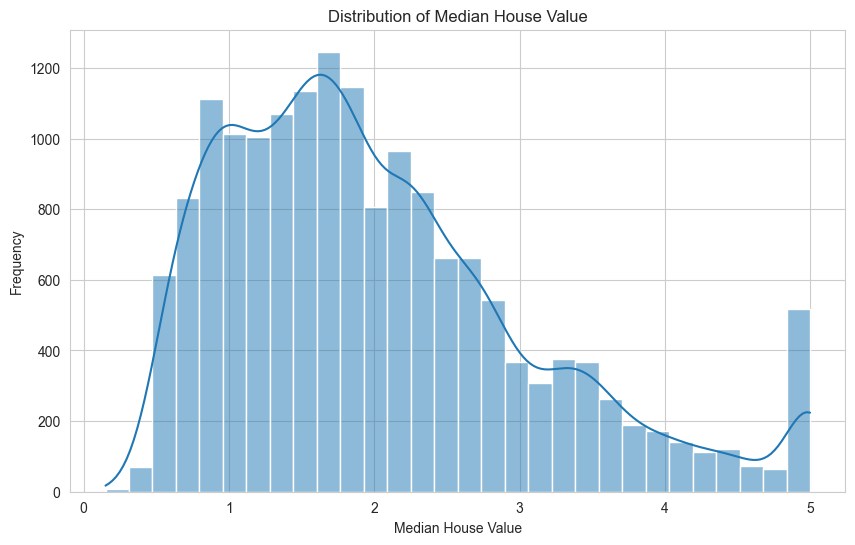

In [7]:
regression_explainer.visualize_data()


Regression Model Evaluation:
Mean Squared Error: 0.41
R-squared: 0.65


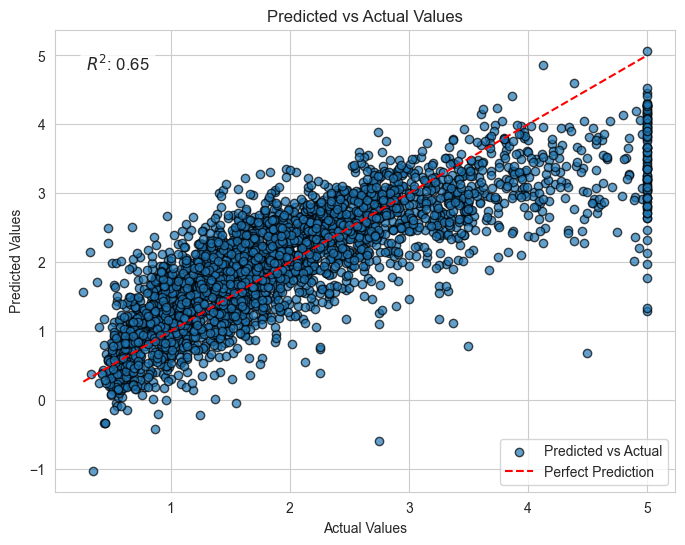

In [8]:
regression_explainer.train_model()
regression_explainer.evaluate_model()


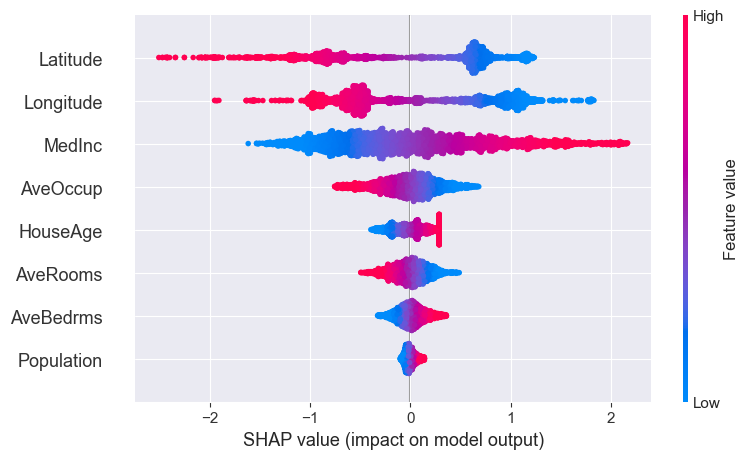

Intercept 2.2592022626084463
Prediction_local [1.43842324]
Right: 1.560287845375719


In [52]:
regression_explainer.explain_model()
regression_explainer.visualize_explanations()


### 3. Classification Model (Breast Cancer)

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import shap
import shap
from lime import lime_tabular

class ClassificationModelExplainer(BaseModelExplainer):
    """
    Classification class for cancer data
    """
    def __init__(self):
        super().__init__()

    def load_data(self):
        """
        load dataset
        """
        cancer = load_breast_cancer()
        self.X = pd.DataFrame(cancer.data, columns=cancer.feature_names)
        self.y = pd.Series(cancer.target)

    def preprocess_data(self):
        """
        splitting into training and test sets then scaling features
        """

        # split the data before scaling to prevent data leakage
        X_train, X_test, y_train, y_test = train_test_split(
            self.X, self.y, test_size=0.2, random_state=42
        )

        # scale features
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        self.X_train = X_train_scaled
        self.X_test = X_test_scaled
        self.y_train = y_train
        self.y_test = y_test
        
    def show_data_statistics(self):
        """
        basic statistics of the dataset
        """
        # summary statistics for features
        print("Feature Statistics:")
        print(self.X.describe())
        print("\nFeature Info:")
        print(self.X.info())
    
    
        # summary statistics for target
        print("\nTarget Statistics:")
        print(self.y.describe())
        print(f"\nValue Counts of Target:\n{self.y.value_counts()}")


    def train_model(self):
        """
        Random Forest Classifier
        """
    
        self.model = RandomForestClassifier(n_estimators=100, random_state=42)
        self.model.fit(self.X_train, self.y_train)

    def evaluate_model(self):
        """
        Evaluate model
        """

        y_pred = self.model.predict(self.X_test)
        accuracy = accuracy_score(self.y_test, y_pred)
        precision = precision_score(self.y_test, y_pred)
        recall = recall_score(self.y_test, y_pred)
        f1 = f1_score(self.y_test, y_pred)
        print(f"Classification Model Evaluation:")
        print(f"Accuracy: {accuracy:.2f}")
        print(f"Precision: {precision:.2f}")
        print(f"Recall: {recall:.2f}")
        print(f"F1 Score: {f1:.2f}")

    def explain_model(self):
        """
        Explain the classification model using SHAP and LIME.
        """
        
        # SHAP Explanation //todo: integrate LIME
        explainer_shap = shap.TreeExplainer(self.model)
        self.shap_values = explainer_shap.shap_values(self.X_test)
        self.explainer_shap = explainer_shap

        # LIME Explanation
        explainer_lime = lime_tabular.LimeTabularExplainer(
            self.X_train,
            feature_names=self.X.columns.tolist(),
            class_names=['Malignant', 'Benign'],
            mode='classification'
        )
        self.explainer_lime = explainer_lime

    def visualize_explanations(self):
        """
        Visualize the SHAP and LIME explanations.
        """
        # SHAP summary plot
        shap.summary_plot(self.shap_values, self.X_test, feature_names=self.X.columns)

        # LIME explanation
        i = 0  
        exp = self.explainer_lime.explain_instance(
            self.X_test[i],
            self.model.predict_proba,
            num_features=5
        )
        exp.show_in_notebook(show_table=True) #DO NOT DELETE ME
        
    def visualize_roc_auc(self):
        """
        Visualize the ROC curve
        """
        from sklearn.metrics import roc_curve, auc
        import matplotlib.pyplot as plt
    
        # Get predicted
        y_proba = self.model.predict_proba(self.X_test)[:, 1]
    
        #  ROC curve and ROC area
        fpr, tpr, thresholds = roc_curve(self.y_test, y_proba)
        roc_auc = auc(fpr, tpr)
    
        # Plotting
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='red', linestyle='--', lw=2, label='Chance Level')
        plt.xlim([-0.05, 1.0])
        plt.ylim([-0.05, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC)')
        plt.legend(loc="lower right")
        plt.grid(True)
        plt.show()
    
        print(f"ROC AUC: {roc_auc:.2f}")

    def visualize_data(self):
        """
        Visualize class distribution
        """
        plt.figure(figsize=(6, 4))
        sns.countplot(x=self.y)
        plt.xlabel('Diagnosis (0 = Malignant, 1 = Benign)')
        plt.ylabel('Frequency')
        plt.title('Diagnosis Distribution')
        plt.show()


In [74]:
classification_explainer = ClassificationModelExplainer()
classification_explainer.load_data()
classification_explainer.preprocess_data()

In [75]:
classification_explainer.show_data_statistics()

Feature Statistics:
       mean radius  mean texture  mean perimeter    mean area  \
count   569.000000    569.000000      569.000000   569.000000   
mean     14.127292     19.289649       91.969033   654.889104   
std       3.524049      4.301036       24.298981   351.914129   
min       6.981000      9.710000       43.790000   143.500000   
25%      11.700000     16.170000       75.170000   420.300000   
50%      13.370000     18.840000       86.240000   551.100000   
75%      15.780000     21.800000      104.100000   782.700000   
max      28.110000     39.280000      188.500000  2501.000000   

       mean smoothness  mean compactness  mean concavity  mean concave points  \
count       569.000000        569.000000      569.000000           569.000000   
mean          0.096360          0.104341        0.088799             0.048919   
std           0.014064          0.052813        0.079720             0.038803   
min           0.052630          0.019380        0.000000             0

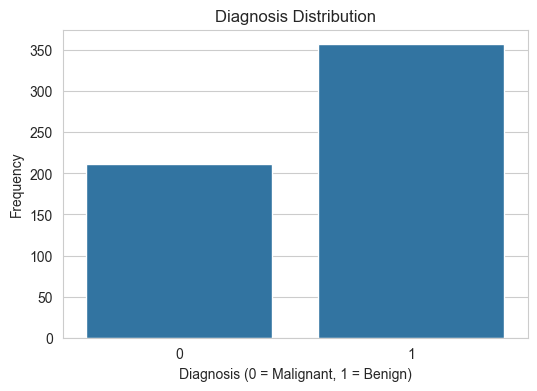

In [76]:
classification_explainer.visualize_data()

In [77]:
classification_explainer.train_model()
classification_explainer.evaluate_model()

Classification Model Evaluation:
Accuracy: 0.96
Precision: 0.96
Recall: 0.99
F1 Score: 0.97


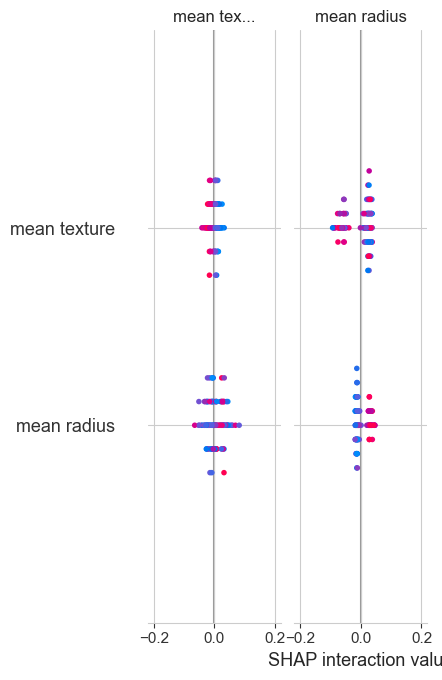

In [78]:
classification_explainer.explain_model()
classification_explainer.visualize_explanations()

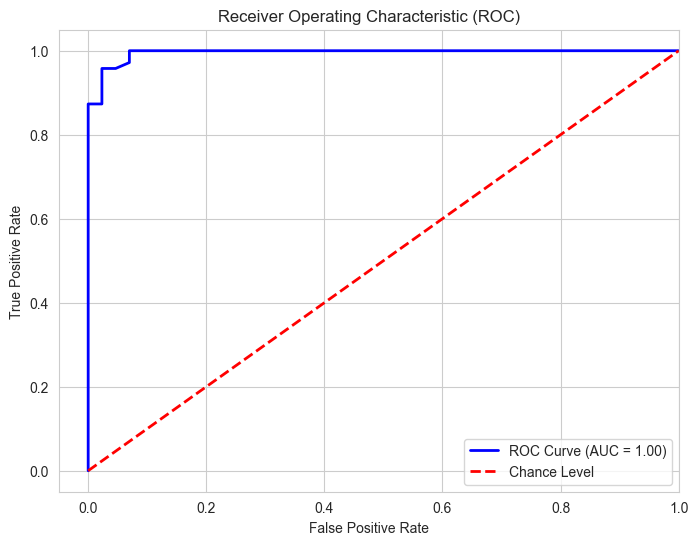

ROC AUC: 1.00


In [79]:
classification_explainer.visualize_roc_auc()

### 4. Open Source GenAI Classifier (AG News)


In [69]:

import torch
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification
from transformers import Trainer, TrainingArguments
from datasets import load_dataset
from transformers_interpret import SequenceClassificationExplainer
import matplotlib.pyplot as plt
import numpy as np
import random
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import random

class OpenSourceGenAIExplainer:
    def __init__(self):
        self.model = None
        self.tokenizer = None
        self.train_dataset = None
        self.test_dataset = None
        self.explainer = None

    def load_data(self):
        """
        load AG News
        """
        dataset = load_dataset('ag_news')
        self.train_dataset = dataset['train']
        self.test_dataset = dataset['test']
        
        print(len(self.train_dataset))
        print(len(self.test_dataset))

    def preprocess_data(self):
        """
        Preprocess the data
        """
        self.tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        self.model = DistilBertForSequenceClassification.from_pretrained(
            'distilbert-base-uncased', num_labels=4
        )

        def tokenize_function(examples):
            return self.tokenizer(
                examples['text'],
                padding='max_length',
                truncation=True,
                max_length=64
            )

        self.train_dataset = self.train_dataset.map(tokenize_function, batched=True)
        self.test_dataset = self.test_dataset.map(tokenize_function, batched=True)

        self.train_dataset.set_format(
            type='torch',
            columns=['input_ids', 'attention_mask', 'label']
        )
        self.test_dataset.set_format(
            type='torch',
            columns=['input_ids', 'attention_mask', 'label']
        )

    def train_model(self):
        """
        Fine-tune DistilBERT
        """
        training_args = TrainingArguments(
            output_dir='./results',
            num_train_epochs=1,
            per_device_train_batch_size=8,
            per_device_eval_batch_size=8,
            evaluation_strategy='epoch',
            save_strategy='epoch',
            logging_dir='./logs',
            logging_steps=10,
            load_best_model_at_end=True,
            metric_for_best_model='accuracy',
            greater_is_better=True,
            report_to='none'
        )

        def compute_metrics(eval_pred):
            logits, labels = eval_pred
            predictions = np.argmax(logits, axis=-1)
            accuracy = np.mean(predictions == labels)
            return {'accuracy': accuracy}

        trainer = Trainer(
            model=self.model,
            args=training_args,
            train_dataset=self.train_dataset.shuffle(seed=42).select(range(2000)),  
            eval_dataset=self.test_dataset.shuffle(seed=42).select(range(500)), 
            compute_metrics=compute_metrics
        )

        trainer.train()

    def evaluate_model(self):
        """
        evaluate
        """
        trainer = Trainer(model=self.model)
        results = trainer.evaluate(eval_dataset=self.test_dataset)
        print(f"Evaluation Results: {results}")

    def explain_model(self, index=None):
        """
        xxplain a prediction
        """
        self.model.to(dtype=torch.float32, device="cpu")
        self.explainer = SequenceClassificationExplainer(
            self.model,
            self.tokenizer
        )
    
        if index is None:
            random.seed()
            index = random.randint(0, len(self.test_dataset) - 1)
    
        print(self.test_dataset[0])

        # get data
        raw_dataset = load_dataset('ag_news')['test']
        sample_text = raw_dataset[index]['text']
        print(f"Sample Text (Index {index}): {sample_text}")
    
        # generate attributions
        attributions = self.explainer(sample_text)
        print("Attributions: ", attributions)
    
        # Visualize
        html_object = self.explainer.visualize()
        with open(f"explanation_{index}.html", "w") as file:
            file.write(html_object.data)
        print(f"Explanation saved to 'explanation_{index}.html'")
        
    def visualize_tsne(self, num_samples=200, random_seed=42):
        """
        Visualize data with t-SNE
        """

        # seed
        random.seed(random_seed)
        np.random.seed(random_seed)
        torch.manual_seed(random_seed)
    
        # Limit samples
        test_size = min(num_samples, len(self.test_dataset))
        subset_indices = list(range(test_size))
    
        # xxtract
        test_input_ids = self.test_dataset['input_ids'][subset_indices]
        test_attention_mask = self.test_dataset['attention_mask'][subset_indices]
        test_labels = self.test_dataset['label'][subset_indices]
    
        # Convert to tensors
        test_input_ids = torch.tensor(test_input_ids)
        test_attention_mask = torch.tensor(test_attention_mask)
        test_labels = torch.tensor(test_labels)
    
        # Create DataLoader
        test_data = TensorDataset(test_input_ids, test_attention_mask, test_labels)
        test_loader = DataLoader(test_data, batch_size=32, shuffle=False)
    
        self.model.eval()
    
        # Store embeddings and labels
        all_embeddings = []
        all_labels = []
    
        with torch.no_grad():
            for batch in test_loader:
                batch_input_ids, batch_attention_mask, batch_y = batch
    
                outputs = self.model(
                    input_ids=batch_input_ids,
                    attention_mask=batch_attention_mask,
                    output_hidden_states=True
                )
    
                last_hidden_state = outputs.hidden_states[-1]
                cls_embeddings = last_hidden_state[:, 0, :]
    
                all_embeddings.append(cls_embeddings.cpu().numpy())
                all_labels.append(batch_y.cpu().numpy())
    
        # Concatenate
        all_embeddings = np.concatenate(all_embeddings, axis=0)
        all_labels = np.concatenate(all_labels, axis=0)
    
        # Apply t-SNE
        tsne = TSNE(n_components=2, random_state=random_seed)
        embeddings_2d = tsne.fit_transform(all_embeddings)
    
        # Plot the 2D embeddings
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=all_labels, cmap='viridis', alpha=0.7, edgecolor='k')
        plt.title('t-SNE Visualization of DistilBERT Embeddings')
        plt.xlabel('Dimension 1')
        plt.ylabel('Dimension 2')
        plt.grid(True)
    
        classes = ['World', 'Sports', 'Business', 'Sci/Tech'] 
        handles, _ = scatter.legend_elements()
        plt.legend(handles, classes, title="Classes", loc='best')
    
        plt.show()



    def visualize_data(self):
        """
        Visualize
        """
        labels = [example['label'] for example in self.train_dataset]
        plt.hist(labels, bins=4, edgecolor='black')
        plt.xlabel('Class Label')
        plt.ylabel('Frequency')
        plt.title('Class Distribution in Training Data')
        plt.show()

In [70]:
explainer = OpenSourceGenAIExplainer()

120000
7600


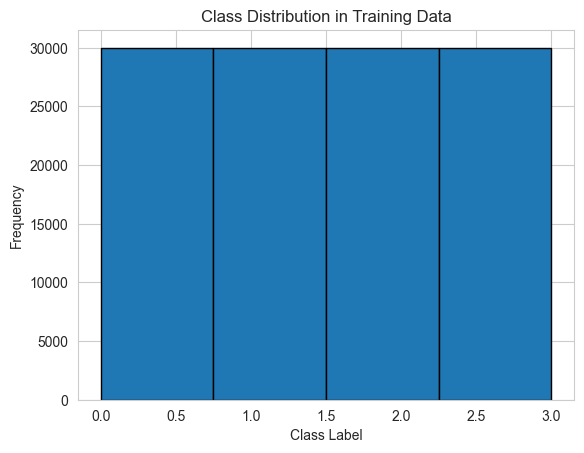

In [71]:
explainer.load_data()
explainer.visualize_data()

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

/var/folders/r4/9ncp61z543v94_5sltg11_bm0000gn/T/ipykernel_80035/2984241617.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = TensorDataset(input_ids, attention_mask, torch.tensor(labels))


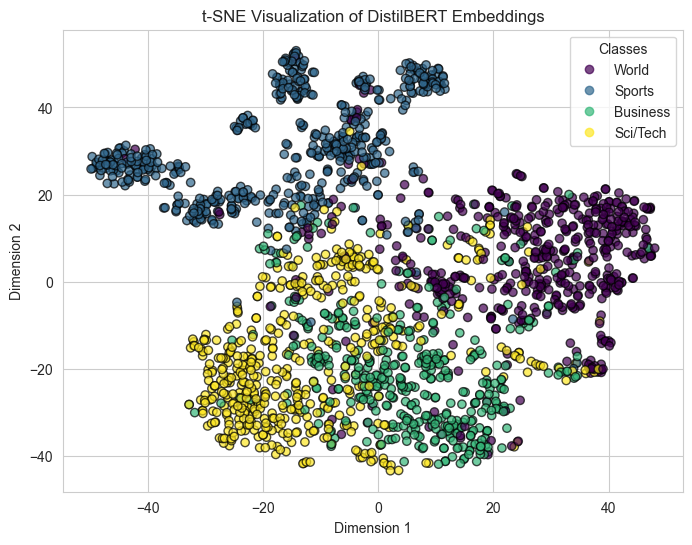

In [58]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, TensorDataset
from sklearn.manifold import TSNE

def visualize_tsne(num_samples=200, random_seed=42):
    np.random.seed(random_seed)
    torch.manual_seed(random_seed)

    # Load a subset
    dataset = load_dataset('ag_news', split='test')
    dataset = dataset.select(range(min(num_samples, len(dataset))))

    tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
    model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=4)
    model.eval()

    # Tokenize
    def tokenize_function(examples):
        return tokenizer(
            examples['text'],
            padding='max_length',
            truncation=True,
            max_length=64
        )

    dataset = dataset.map(tokenize_function, batched=True)
    dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

    # Extract tensors
    input_ids = dataset['input_ids']
    attention_mask = dataset['attention_mask']
    labels = dataset['label']

    # Create a DataLoader
    data = TensorDataset(input_ids, attention_mask, torch.tensor(labels))
    loader = DataLoader(data, batch_size=32, shuffle=False)

    # Extract CLS embeddings
    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for batch in loader:
            batch_input_ids, batch_attention_mask, batch_labels = batch
            outputs = model(batch_input_ids, attention_mask=batch_attention_mask, output_hidden_states=True)
            # Last hidden state [batch_size, seq_len, hidden_dim]
            last_hidden_state = outputs.hidden_states[-1]
            # CLS token embedding is at index 0
            cls_embeddings = last_hidden_state[:, 0, :].cpu().numpy()
            all_embeddings.append(cls_embeddings)
            all_labels.append(batch_labels.cpu().numpy())

    # Concatenate all embeddings and labels
    all_embeddings = np.concatenate(all_embeddings, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=random_seed)
    embeddings_2d = tsne.fit_transform(all_embeddings)

    # Classes
    classes = ['World', 'Sports', 'Business', 'Sci/Tech']

    # Plot the 2D embeddings
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=all_labels, cmap='viridis', alpha=0.7, edgecolor='k')
    plt.title('t-SNE Visualization of DistilBERT Embeddings')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.grid(True)

    # Legend
    handles, _ = scatter.legend_elements()
    plt.legend(handles, classes, title="Classes", loc='best')

    plt.show()

visualize_tsne(num_samples=2000, random_seed=42)

In [128]:
explainer.preprocess_data()


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/120000 [00:00<?, ? examples/s]

Map:   0%|          | 0/7600 [00:00<?, ? examples/s]

In [129]:
explainer.train_model()


/Users/alkhalifas/Documents/Github/cs6140-machine-learning/.venv/lib/python3.11/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.447100,0.388344,0.884000


In [130]:
explainer.evaluate_model()

Evaluation Results: {'eval_loss': 0.35946494340896606, 'eval_model_preparation_time': 0.0006, 'eval_runtime': 32.5447, 'eval_samples_per_second': 233.525, 'eval_steps_per_second': 29.191}


In [131]:
from IPython.core.display import display


In [132]:
explainer.explain_model()


{'label': tensor(2), 'input_ids': tensor([  101, 10069,  2005,  1056,  1050, 11550,  2044,  7566,  9209,  5052,
         3667,  2012,  6769,  2047,  8095,  2360,  2027,  2024,  1005,  9364,
         1005,  2044,  7566,  2007, 16654,  6687,  3813,  2976,  9587, 24848,
         1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}
Sample Text (Index 6081): Dream TV Screen, Now in Size Large The most desired electronic gift item for this holiday season is a plasma TV. You might, however, want to consider something that wasn't even in the running: L.C.D

Explanation saved to 'explanation_6081.html'


In [133]:
explainer.explain_model()


{'label': tensor(2), 'input_ids': tensor([  101, 10069,  2005,  1056,  1050, 11550,  2044,  7566,  9209,  5052,
         3667,  2012,  6769,  2047,  8095,  2360,  2027,  2024,  1005,  9364,
         1005,  2044,  7566,  2007, 16654,  6687,  3813,  2976,  9587, 24848,
         1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}
Sample Text (Index 52): Restive Maldives eases curfew after rounding up dissidents (AFP) AFP - A curfew in the capital of the Maldives was eased but parliament sessions were put off indefinitely and emergency rule continued 

Explanation saved to 'explanation_52.html'


In [134]:
explainer.explain_model()


{'label': tensor(2), 'input_ids': tensor([  101, 10069,  2005,  1056,  1050, 11550,  2044,  7566,  9209,  5052,
         3667,  2012,  6769,  2047,  8095,  2360,  2027,  2024,  1005,  9364,
         1005,  2044,  7566,  2007, 16654,  6687,  3813,  2976,  9587, 24848,
         1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}
Sample Text (Index 4870): 'Smelly' mates guide seabirds Seabirds called prions, which mate for life, find their nests by sniffing out their partners, scientists say.
Attributions:  [('[CLS]', 0.0), ("'", -0.11308386985313947

Explanation saved to 'explanation_4870.html'


In [135]:
explainer.explain_model()


{'label': tensor(2), 'input_ids': tensor([  101, 10069,  2005,  1056,  1050, 11550,  2044,  7566,  9209,  5052,
         3667,  2012,  6769,  2047,  8095,  2360,  2027,  2024,  1005,  9364,
         1005,  2044,  7566,  2007, 16654,  6687,  3813,  2976,  9587, 24848,
         1012,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0]), 'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])}
Sample Text (Index 192): Kerry assails Bush troop withdrawal plan (AFP) AFP - Democratic White House hopeful Senator John Kerry warned that President George W. Bush's plan to withdraw 70,000 troops from Europe and Asia would

Explanation saved to 'explanation_192.html'


### 5. Close Source GenAI Classifier (Sentiment)


In [163]:
from openai import OpenAI
import matplotlib.pyplot as plt

API_KEY = "sk-proj-xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx"

client = OpenAI(api_key=API_KEY)

class ClosedSourceGenAIExplainer:
    def __init__(self):
        self.prompts = None
        self.responses = None

    def set_prompts(self):
        """
        Set up sample prompts for sentiment analysis.
        """
        self.prompts = [
            "Classify the sentiment of the following text as positive, negative, or neutral:\n\n'I love the way this product works! It's amazing.'",
            "Classify the sentiment of the following text as positive, negative, or neutral:\n\n'This is the worst experience I’ve ever had.'",
            "Classify the sentiment of the following text as positive, negative, or neutral:\n\n'The product is okay, but it could be better.'",
            "Classify the sentiment of the following text as positive, negative, or neutral:\n\n'not bad, but not good.'",
            "Classify the sentiment of the following text as positive, negative, or neutral:\n\n'this product was excellent in the worst way possible.'",
            "Classify the sentiment of the following text as positive, negative, or neutral:\n\n'The dining experience overwhelmingly positive.'",
            "Classify the sentiment of the following text as positive, negative, or neutral:\n\n'Definitely an interesting experience.'",
            "Classify the sentiment of the following text as positive, negative, or neutral:\n\n'This place was terrible.'",
            
        ]

    def get_responses(self):
        """
        Get responses from the OpenAI API
        """
        self.responses = []
        for prompt in self.prompts:
            response = client.chat.completions.create(
                model="gpt-4",
                messages=[
                    {"role": "system", "content": "You are a helpful assistant."},
                    {"role": "user", "content": prompt}
                ],
                temperature=0.7
            )
            self.responses.append(response)
        
        return self.responses

    def explain_model(self):
        """
        Explore explainability through prompt engineering and token-level importances
        """
        for i, response in enumerate(self.responses):
            
            print(f"\nPrompt {i+1}: {self.prompts[i]}")
            # print(">>>> ", response.choices[0].message.content)
            content = response.choices[0].message.content
            print(f"Response: {content}")

            # prompt: //todo: modify prompts 
            modified_prompt = self.prompts[i] + "\n\nExplain your reasoning step by step."
            reasoning_response = client.chat.completions.create(
                model="gpt-4o",
                messages=[
                    {"role": "system", "content": "You are a helpful assistant."},
                    {"role": "user", "content": modified_prompt}
                ],
                temperature=0.7
            )
            print(f"Reasoning Response: {reasoning_response.choices[0].message.content}")

            # impact of token importance
            self.analyze_token_importance(self.prompts[i])

    def analyze_token_importance(self, prompt):
        """
        Analyze the importance of tokens
        """
        words = prompt.split()
        original_response = client.chat.completions.create(
            model="gpt-4",
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt}
            ],
            temperature=0.7
        )
    
        # Extract the original sentiment confidence:
        original_content = original_response.choices[0].message.content
        original_sentiment = self.extract_sentiment_confidence(original_content)
        print(f"Original Sentiment Confidence: {original_sentiment}")
    
        # Calculate importance:
        scores = []
        for i, word in enumerate(words):
            # Remove one word at a time
            modified_prompt = " ".join(words[:i] + words[i+1:])
            modified_response = client.chat.completions.create(
                model="gpt-4",
                messages=[
                    {"role": "system", "content": "You are a helpful assistant."},
                    {"role": "user", "content": modified_prompt}
                ],
                temperature=0.7
            )
    
            # Extract modified sentiment confidence
            modified_content = modified_response.choices[0].message.content
            modified_sentiment = self.extract_sentiment_confidence(modified_content)
            print(f"Token Removed: {word}, Modified Sentiment Confidence: {modified_sentiment}")
    
            # Calculate the change in confidence:
            score = abs(original_sentiment - modified_sentiment)
            scores.append(score)
    
        # Visualize token importance
        print(f"Token Impact Scores: {scores}")
        plt.figure(figsize=(10, 6))
        plt.bar(range(len(words)), scores, color='blue', alpha=0.7)
        plt.xticks(range(len(words)), words, rotation=90)
        plt.xlabel('Tokens')
        plt.ylabel('Impact Score (Change in Confidence)')
        plt.title('Token Importance Analysis')
        plt.show()


    
    def extract_sentiment_confidence(self, content):
        """
        xxtract sentiment confidence from the response
        """
        content = content.lower()
        if 'positive' in content:
            return 1.0  
        elif 'negative' in content:
            return 0.0  
        elif 'neutral' in content:
            return 0.5  
        else:
            return 0.5  



    def visualize_responses(self):
        """
        visualize the distribution
        """
        sentiments = []
        for response in self.responses:
            content = response.choices[0].message.content.lower()
            if 'positive' in content:
                sentiments.append('Positive')
            elif 'negative' in content:
                sentiments.append('Negative')
            else:
                sentiments.append('Neutral')

        plt.figure(figsize=(8, 6))
        plt.hist(sentiments, bins=3, color='skyblue', edgecolor='black', alpha=0.7)
        plt.xlabel('Sentiments')
        plt.ylabel('Frequency')
        plt.title('Sentiment Classification Distribution')
        plt.show()


In [164]:
explainer = ClosedSourceGenAIExplainer()
explainer.set_prompts()


In [165]:
responses = explainer.get_responses()
responses

[ChatCompletion(id='chatcmpl-AX9iUjiujoWNwPH4B3IDU6v9UlfwA', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The sentiment of this text is positive.', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None))], created=1732465538, model='gpt-4-0613', object='chat.completion', service_tier=None, system_fingerprint=None, usage=CompletionUsage(completion_tokens=8, prompt_tokens=45, total_tokens=53, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=0))),
 ChatCompletion(id='chatcmpl-AX9iWJwX70BfJZUVcnMUhvfAuvJV8', choices=[Choice(finish_reason='stop', index=0, logprobs=None, message=ChatCompletionMessage(content='The sentiment of the text is negative.', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None))], created=1732


Prompt 1: Classify the sentiment of the following text as positive, negative, or neutral:

'I love the way this product works! It's amazing.'
Response: The sentiment of this text is positive.
Reasoning Response: The sentiment of the text is positive.

Here is the step-by-step reasoning:

1. The sentence begins with the word 'love', which is a strong positive emotion. This indicates a positive sentiment.
2. The user also mentions that they are pleased with how the product works. This statement further supports the positive sentiment.
3. The sentence concludes with 'It's amazing.', which is a positive phrase. 'Amazing' is an adjective often used to express admiration or excitement, which is a positive sentiment.
4. There are no negative or neutral words in the sentence, eliminating the possibility of negative or neutral sentiment.

So, considering the use of words and phrases that depict positive emotions and admiration, the sentiment of the text is positive.
Original Sentiment Confiden

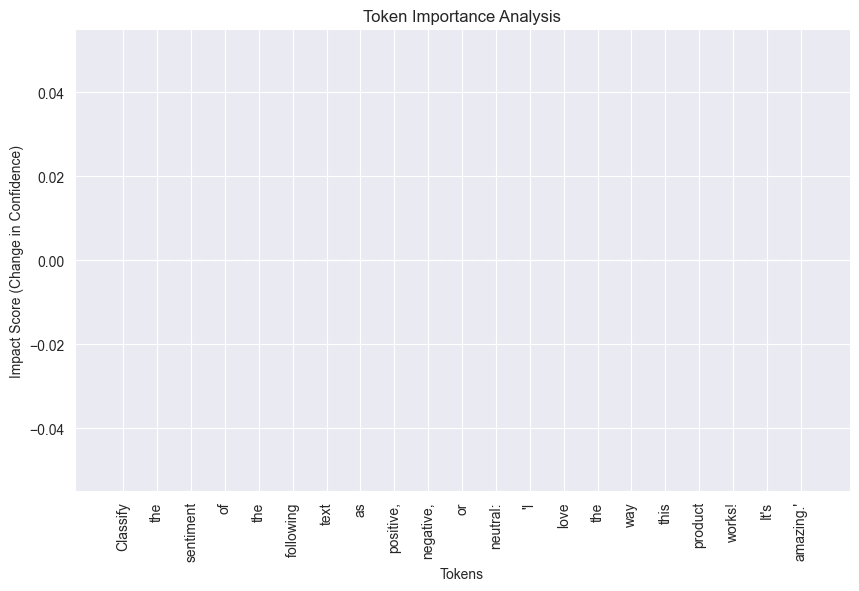


Prompt 2: Classify the sentiment of the following text as positive, negative, or neutral:

'This is the worst experience I’ve ever had.'
Response: The sentiment of the text is negative.
Reasoning Response: The sentiment of the text 'This is the worst experience I’ve ever had' is negative.

Reasoning:

1. The text is expressing a personal experience of the speaker.
2. The word 'worst' is used, which is a negative superlative adjective. It indicates the lowest quality or standard.
3. The phrase 'ever had' amplifies the negative sentiment as it suggests that among all experiences the speaker has had, this one ranks the lowest.
4. Overall, the text conveys a strong dissatisfaction or disappointment, which is a negative emotion. Hence, the sentiment is classified as negative.
Original Sentiment Confidence: 0.0
Token Removed: Classify, Modified Sentiment Confidence: 0.0
Token Removed: the, Modified Sentiment Confidence: 0.0
Token Removed: sentiment, Modified Sentiment Confidence: 0.0
Token 

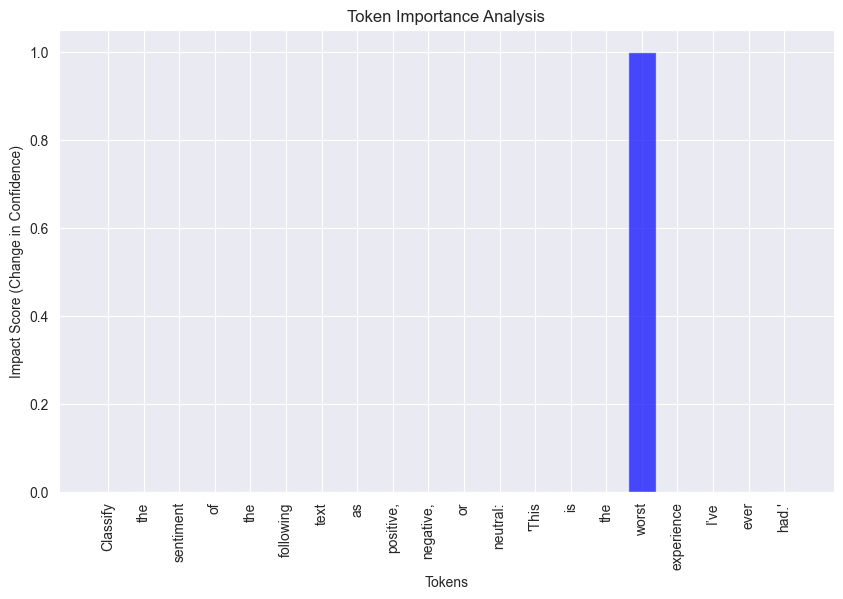


Prompt 3: Classify the sentiment of the following text as positive, negative, or neutral:

'The product is okay, but it could be better.'
Response: Neutral
Reasoning Response: The sentiment of the text is neutral.

Step 1: Identify the sentiment words or phrases in the sentence. In this case, they are 'okay' and 'could be better'.

Step 2: Understand the meaning of these words or phrases. 'Okay' means something is acceptable but not exceptionally good, indicating a neutral or possibly slightly positive sentiment. 'Could be better' implies that while the product is not bad, there is room for improvement, indicating a neutral or possibly slightly negative sentiment.

Step 3: Balance these sentiments against each other. In this case, the slightly positive sentiment from 'okay' and the slightly negative sentiment from 'could be better' balance each other out, resulting in an overall neutral sentiment. 

Step 4: Consider the overall context of the sentence. Here, the speaker is expressing 

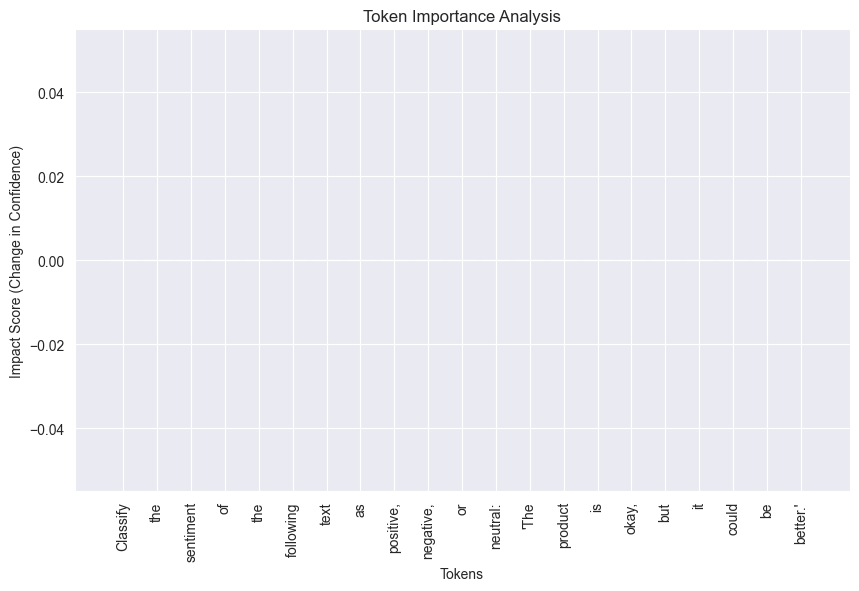


Prompt 4: Classify the sentiment of the following text as positive, negative, or neutral:

'not bad, but not good.'
Response: neutral
Reasoning Response: The sentiment of the text 'not bad, but not good.' can be classified as neutral.

The reasoning behind this is as follows:

1. The text consists of two parts. The first part 'not bad' negates a negative sentiment, which leans towards a positive sentiment.
2. The second part 'but not good' negates a positive sentiment, which leans towards a negative sentiment.
3. When considered together, the positive and negative aspects balance each other out, resulting in a neutral sentiment overall.
Original Sentiment Confidence: 0.5
Token Removed: Classify, Modified Sentiment Confidence: 0.5
Token Removed: the, Modified Sentiment Confidence: 0.5
Token Removed: sentiment, Modified Sentiment Confidence: 0.5
Token Removed: of, Modified Sentiment Confidence: 0.5
Token Removed: the, Modified Sentiment Confidence: 0.5
Token Removed: following, Modified

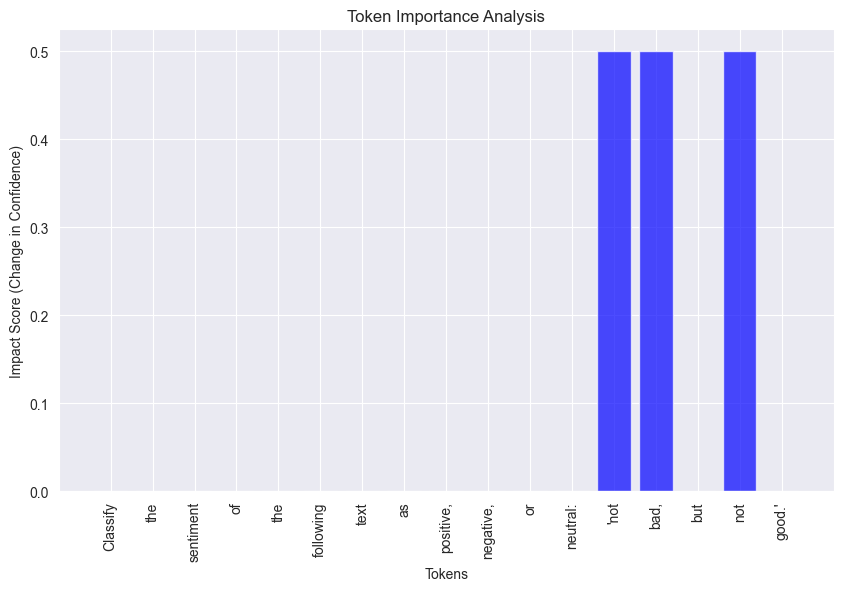


Prompt 5: Classify the sentiment of the following text as positive, negative, or neutral:

'this product was excellent in the worst way possible.'
Response: Negative
Reasoning Response: The sentiment of the text is negative. 

Reasoning: 
The text initially seems positive because of the word "excellent." However, the phrase "in the worst way possible" flips the sentiment to negative. This phrase indicates that the excellence referred to is not good or desirable, therefore, the overall sentiment is negative. The speaker is expressing dissatisfaction with the product, so the sentiment is negative.
Original Sentiment Confidence: 0.0
Token Removed: Classify, Modified Sentiment Confidence: 0.0
Token Removed: the, Modified Sentiment Confidence: 0.0
Token Removed: sentiment, Modified Sentiment Confidence: 0.0
Token Removed: of, Modified Sentiment Confidence: 0.0
Token Removed: the, Modified Sentiment Confidence: 0.0
Token Removed: following, Modified Sentiment Confidence: 0.0
Token Removed: 

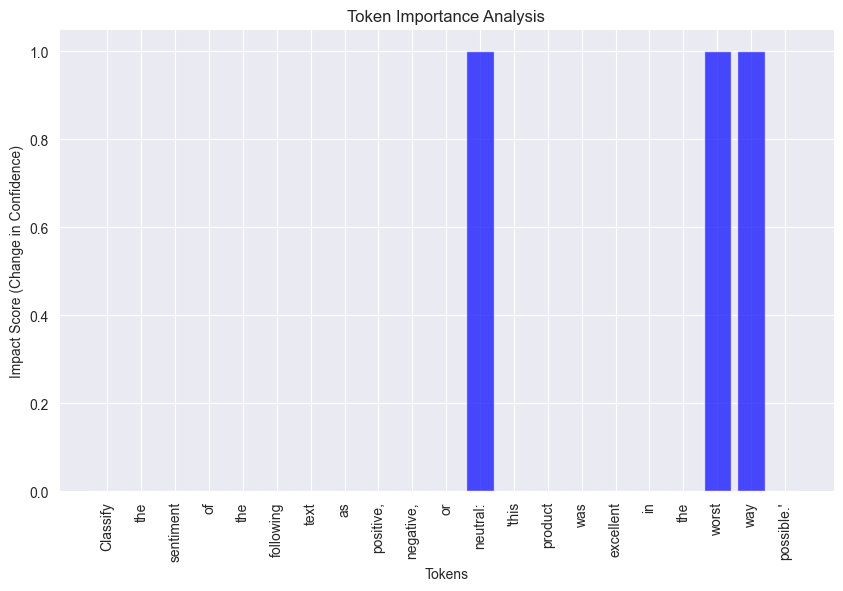


Prompt 6: Classify the sentiment of the following text as positive, negative, or neutral:

'The dining experience overwhelmingly positive.'
Response: The sentiment of the text is positive.
Reasoning Response: The sentiment of the text: 'The dining experience overwhelmingly positive.' is Positive.

Reasoning Step by Step:

1. The text talks about a 'dining experience', which is the context here.
2. The word 'overwhelmingly' is an adverb that is used to emphasize the feeling or sentiment.
3. The word 'positive' is an adjective that describes the sentiment directly. In this context, it is used to express satisfaction or pleasure.
4. There aren't any negative or neutral words or phrases in the text.
5. Taking these points into account, the sentiment expressed about the dining experience is clearly positive as it expresses a high degree of satisfaction or pleasure.
Original Sentiment Confidence: 1.0
Token Removed: Classify, Modified Sentiment Confidence: 1.0
Token Removed: the, Modified Se

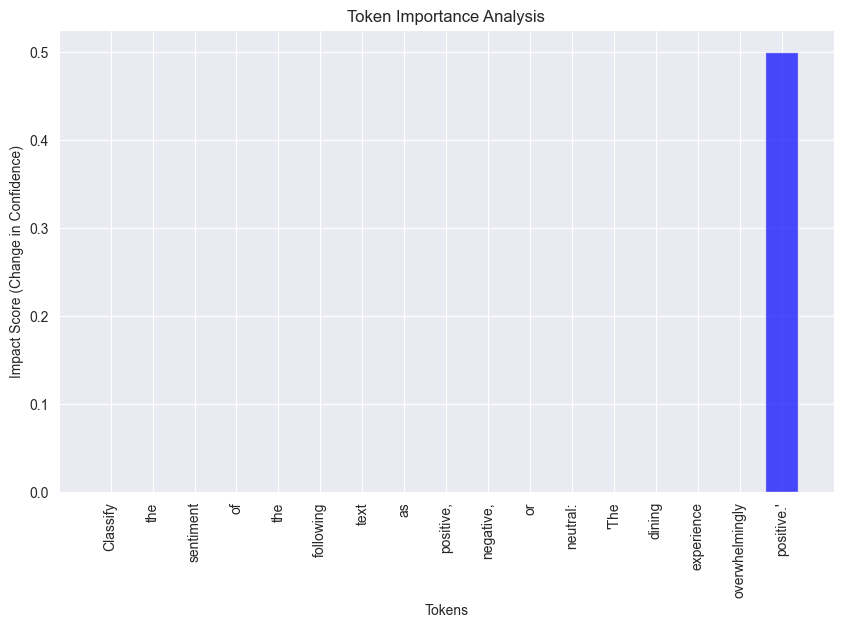


Prompt 7: Classify the sentiment of the following text as positive, negative, or neutral:

'Definitely an interesting experience.'
Response: Positive
Reasoning Response: The sentiment of the text 'Definitely an interesting experience.' can be classified as 'Positive'.

Reasoning:
1. The adverb 'Definitely' signifies a certainty or firmness, which in this context does not express a negative or neutral sentiment.
2. The adjective 'Interesting' is generally associated with something that attracts attention or arouses curiosity or engagement. It usually carries a positive connotation.
3. The noun 'Experience' is neutral by itself. However, when combined with 'interesting', it leans more toward a positive sentiment.
4. Overall, the statement does not express dissatisfaction, sadness, or any negative feelings, nor is it simply stating a fact or an unbiased observation which would be neutral.
5. Hence, the sentiment is positive as it depicts a sense of enjoyment or fascination.
Original Sent

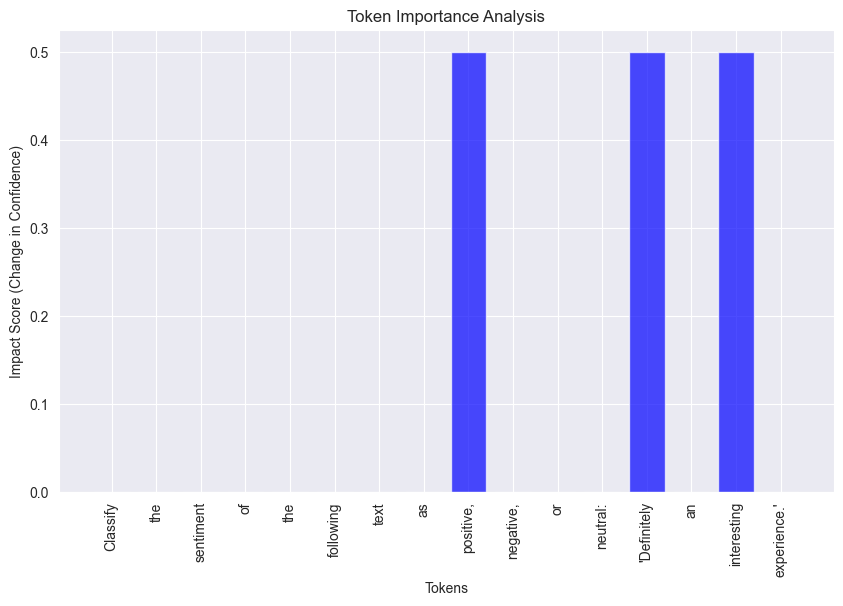


Prompt 8: Classify the sentiment of the following text as positive, negative, or neutral:

'This place was terrible.'
Response: The sentiment of the text is negative.
Reasoning Response: The sentiment of the text 'This place was terrible.' is negative.

The reasoning is as follows:

1. Sentiment analysis involves determining whether a piece of writing is positive, negative or neutral. It's often used to determine how people feel about a particular subject.
   
2. In this sentence, the key word that helps us understand the sentiment is 'terrible'. The word 'terrible' is generally used to express a strong negative opinion about something. 

3. The sentence as a whole, 'This place was terrible', implies that the speaker had a bad experience at the place they are referring to. 

Therefore, the sentiment expressed in this sentence is negative.
Original Sentiment Confidence: 0.0
Token Removed: Classify, Modified Sentiment Confidence: 0.0
Token Removed: the, Modified Sentiment Confidence: 0.

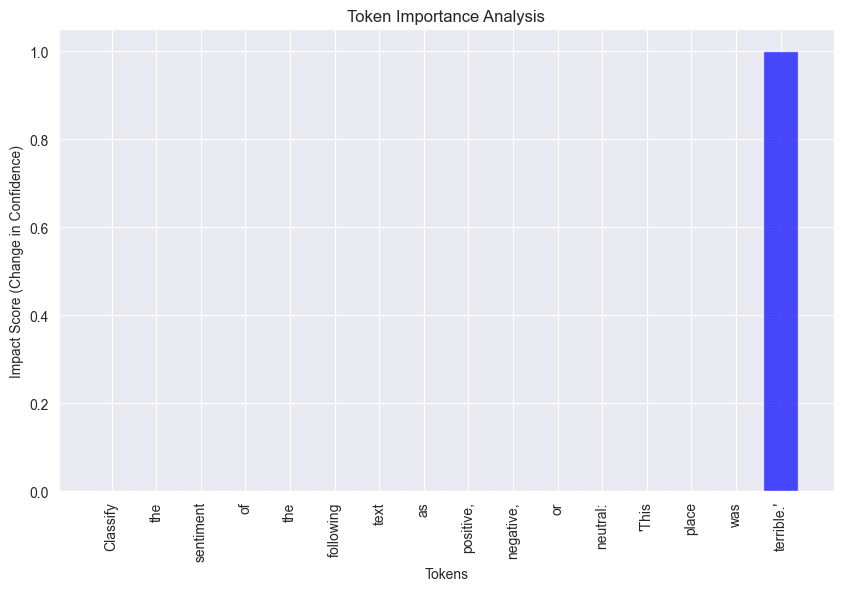

In [166]:
explainer.explain_model()

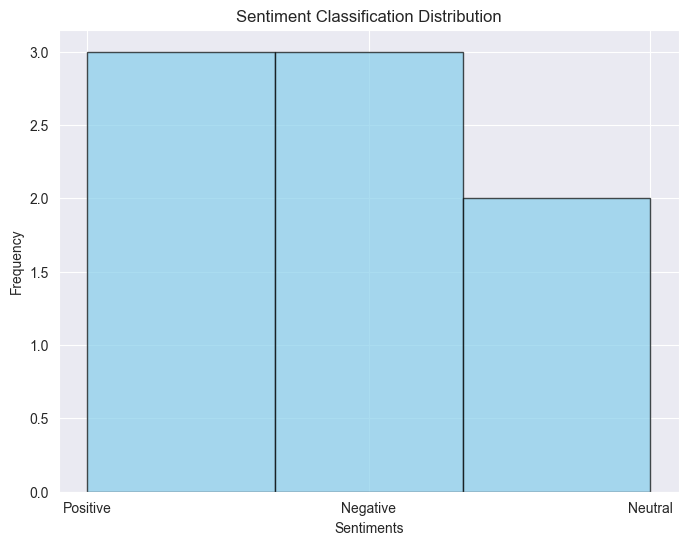

In [167]:
explainer.visualize_responses()


### 6. Random Forest Classifier with Counterfactual Explainability (Iris)


In [174]:
import dice_ml
from dice_ml import Dice
import pandas as pd
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

class CounterfactualExplainer:
    def __init__(self):
        self.model = None
        self.data = None
        self.dice = None
        self.dice_explainer = None

    def load_data(self):
        """
        Iris dataset
        """
        iris = load_iris()
        self.data = pd.DataFrame(iris.data, columns=iris.feature_names)
        self.data['target'] = iris.target

        self.data = self.data[self.data['target'].isin([0, 1])]
        self.X = self.data.drop('target', axis=1)
        self.y = self.data['target']

    def train_model(self):
        """
        Train classification model
        """
        X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=0.2, random_state=42)
        self.X_train, self.X_test, self.y_train, self.y_test = X_train, X_test, y_train, y_test

        self.model = RandomForestClassifier(random_state=42)
        self.model.fit(X_train, y_train)

    def create_dice_explainer(self):
        """
        Create a DiCE explainer
        """
        dice_data = dice_ml.Data(dataframe=self.data, continuous_features=self.X.columns.tolist(), outcome_name='target')

        # Wrap trained model for DiCE
        dice_model = dice_ml.Model(model=self.model, backend='sklearn')

        # Create DiCE explainer
        self.dice_explainer = Dice(dice_data, dice_model)

    def generate_counterfactuals(self, query_instance, desired_class):
        """
        Generate counterfactual explanations for a query instance
        """
        # Generate counterfactuals
        counterfactuals = self.dice_explainer.generate_counterfactuals(
            query_instances=query_instance,
            total_CFs=5,  
            desired_class=desired_class
        )

        # Show the counterfactual explanations
        counterfactuals.visualize_as_dataframe(show_only_changes=True)
        return counterfactuals

    def example_run(self):
        """
        Full run
        """
        # Load
        self.load_data()
        self.train_model()
        self.create_dice_explainer()

        # Pick a query instance
        query_instance = self.X_test.iloc[[0]] 
        print("Query Instance:")
        print(query_instance)

        # Generate counterfactuals
        print("\nGenerating Counterfactual Explanations...")
        cf_examples = self.generate_counterfactuals(query_instance=query_instance, desired_class=1)
        return cf_examples

In [175]:
explainer = CounterfactualExplainer()


In [176]:
cf_examples = explainer.example_run()

Query Instance:
    sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
83                6.0               2.7                5.1               1.6

Generating Counterfactual Explanations...


100%|██████████| 1/1 [00:00<00:00,  9.79it/s]

Query instance (original outcome : 1)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,6.0,2.7,5.1,1.6,1



Diverse Counterfactual set (new outcome: 1)


,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,-,-,4.6,-,-
1,-,-,-,-,-
2,-,-,4.4,0.4,-
3,4.3,3.3,-,-,-
4,-,3.5,4.0,-,-


### 7. Deep Learning:


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from captum.attr import IntegratedGradients, visualization
import matplotlib.pyplot as plt
import numpy as np

In [11]:
class DeepLearningModelExplainer(BaseModelExplainer):
    def __init__(self):
        super().__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def load_data(self):
        """
        Load MNIST
        """
        transform = transforms.Compose([transforms.ToTensor()])
        train_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
        test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

        self.train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
        self.test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

    def build_model(self):
        """
        Define neural network
        """
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28 * 28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 10)
        ).to(self.device)

    def train_model(self, epochs=5):
        """
        Train my model
        """
        self.model.train()
        optimizer = optim.Adam(self.model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            total_loss = 0
            for data, target in self.train_loader:
                data, target = data.to(self.device), target.to(self.device)
                optimizer.zero_grad()
                output = self.model(data)
                loss = criterion(output, target)
                loss.backward()
                optimizer.step()
                total_loss += loss.item()

            print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(self.train_loader):.4f}")

    def evaluate_model(self):
        """
        Evaluate the model
        """
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data, target in self.test_loader:
                data, target = data.to(self.device), target.to(self.device)
                output = self.model(data)
                _, predicted = torch.max(output, 1)
                total += target.size(0)
                correct += (predicted == target).sum().item()

        accuracy = correct / total
        print(f"Test Accuracy: {accuracy:.2%}")

    def explain_model(self):
        """
        Explain using Integrated Gradients
        """
        self.model.eval()
        ig = IntegratedGradients(self.model)

        # Get a batch
        data_iter = iter(self.test_loader)
        data, target = next(data_iter)
        data, target = data.to(self.device), target.to(self.device)

        # Select one sample to explain
        clear_sample = data[0:1] 
        baseline = torch.zeros_like(clear_sample) 
        target_class = target[0].item()

        # Compute attributions
        attributions_clear, delta_clear = ig.attribute(
            clear_sample, baselines=baseline, target=target_class, return_convergence_delta=True
        )

        # Create noisy input
        noise = torch.randn_like(clear_sample) * 0.5  
        noisy_sample = torch.clamp(clear_sample + noise, 0, 1)  

        # Compute attributions
        attributions_noisy, delta_noisy = ig.attribute(
            noisy_sample, baselines=baseline, target=target_class, return_convergence_delta=True
        )

        # Visualize clear and noisy inputs with their attributions: //todo lets add multiple to explore all numbers?
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes[0, 0].imshow(clear_sample.squeeze().cpu().numpy(), cmap="gray")
        axes[0, 0].set_title("Clear Input")
        axes[0, 0].axis("off")

        axes[0, 1].imshow(attributions_clear.squeeze().cpu().detach().numpy(), cmap="hot")
        axes[0, 1].set_title("Attributions (Clear Input)")
        axes[0, 1].axis("off")

        axes[0, 2].text(0.5, 0.5, f"Convergence Delta: {delta_clear.item():.4f}", ha='center', va='center', fontsize=12)
        axes[0, 2].set_title("Convergence Delta (Clear Input)")
        axes[0, 2].axis("off")

        axes[1, 0].imshow(noisy_sample.squeeze().cpu().numpy(), cmap="gray")
        axes[1, 0].set_title("Noisy Input")
        axes[1, 0].axis("off")

        axes[1, 1].imshow(attributions_noisy.squeeze().cpu().detach().numpy(), cmap="hot")
        axes[1, 1].set_title("Attributions (Noisy Input)")
        axes[1, 1].axis("off")

        axes[1, 2].text(0.5, 0.5, f"Convergence Delta: {delta_noisy.item():.4f}", ha='center', va='center', fontsize=12)
        axes[1, 2].set_title("Convergence Delta (Noisy Input)")
        axes[1, 2].axis("off")

        plt.tight_layout()
        plt.show()


    def example_run(self):
        """
        Do example run
        """
        self.load_data()
        self.build_model()
        self.train_model(epochs=3)
        self.evaluate_model()
        self.explain_model()

Epoch 1/3, Loss: 0.3483
Epoch 2/3, Loss: 0.1435
Epoch 3/3, Loss: 0.0980
Test Accuracy: 96.68%


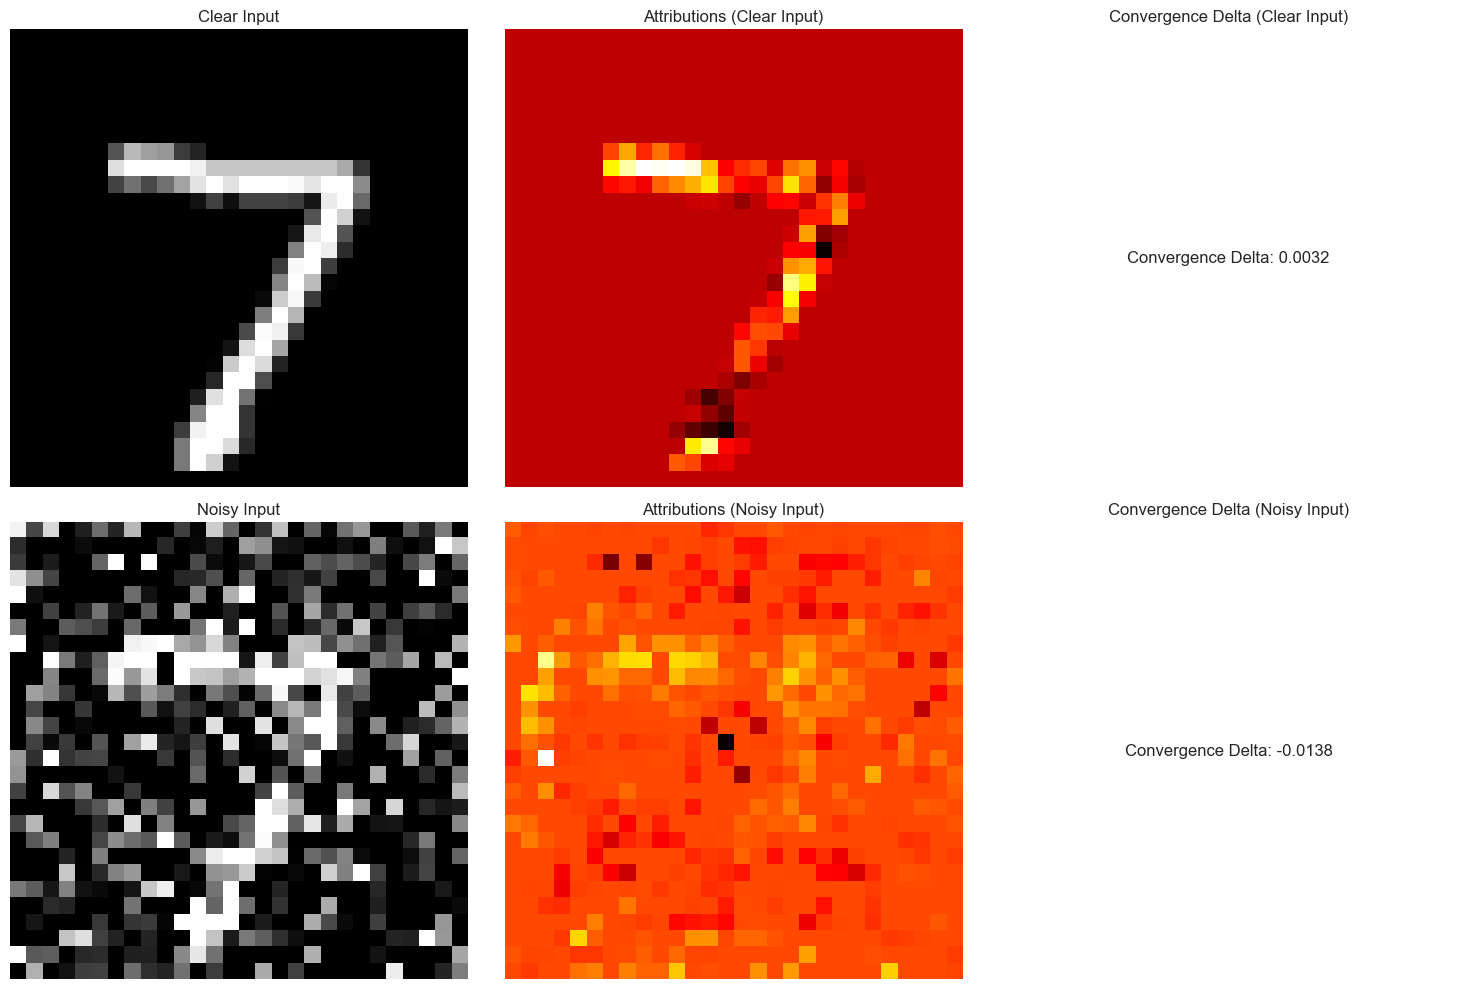

In [12]:
explainer = DeepLearningModelExplainer()
explainer.example_run()